# Predicting positive and negative links 


In [1]:
import pickle
import pandas as pd
import numpy as np
import graph_tool as gt
import graph_tool.topology as top
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import matplotlib.pylab as plt
%matplotlib inline 
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from collections import Counter
from __future__ import division

## Wikipedia

We perform the same experiments for the wikipedia signed graph. 

In [37]:
filename = "wikiElec.ElecBs3.csv"
g = gt.load_graph_from_csv("./data/{}".format(filename), directed=True, eprop_types=['int'], eprop_names=['weight'], string_vals=True)
g.is_directed()

True

In [38]:
triad_features  = pickle.load(open("./data/wiki2Elec.ElecBs3.csv.triad_features.pk".format(filename), 'rb'))
degree_features = pickle.load(open("./data/wiki2Elec.ElecBs3.csv.graph_features.pk".format(filename), 'rb'))
common_neighbors = pickle.load(open("./data/wiki2Elec.ElecBs3.csv.common_neighbors.pk".format(filename), 'rb'))
counts_3 = pickle.load(open("./data/wiki2Elec.ElecBs3.csv.paths_of_length_3_counts.pk".format(filename), 'rb'))
counts_4 = pickle.load(open("./data/wiki2Elec.ElecBs3.csv.paths_of_length_4_counts.pk".format(filename), 'rb'))

In [39]:
counts_4

{(3350, 3651): [24, 13],
 (1404, 1524): [29, 8],
 (217, 820): [4, 7],
 (5129, 6053): [4, 2],
 (535, 1254): [0, 4],
 (5410, 5405): [0, 0],
 (1420, 916): [9, 13],
 (5859, 4522): [0, 6],
 (422, 3904): [40, 76],
 (3594, 4271): [11, 9],
 (241, 2371): [5, 11],
 (1131, 846): [3, 11],
 (1062, 5425): [2, 3],
 (2396, 673): [10, 10],
 (216, 363): [1, 19],
 (4897, 5131): [21, 32],
 (422, 5871): [10, 16],
 (801, 2017): [11, 30],
 (4261, 5827): [13, 28],
 (2584, 5395): [7, 23],
 (5706, 4522): [9, 16],
 (6632, 5782): [5, 11],
 (10, 1549): [4, 3],
 (1370, 2377): [8, 50],
 (111, 3751): [21, 22],
 (5669, 3990): [3, 8],
 (1660, 1658): [0, 0],
 (3329, 896): [15, 9],
 (1649, 1723): [5, 7],
 (2559, 2017): [6, 6],
 (3990, 3619): [21, 19],
 (1430, 962): [0, 0],
 (778, 6026): [28, 24],
 (1002, 5104): [7, 4],
 (78, 967): [3, 13],
 (5153, 4961): [3, 8],
 (5143, 1972): [17, 26],
 (5470, 5329): [11, 20],
 (1846, 2226): [7, 9],
 (2172, 3150): [29, 24],
 (2127, 1682): [12, 28],
 (5954, 4687): [1, 1],
 (756, 3762): [

In [40]:
from collections import Counter
from __future__ import division
x=Counter(common_neighbors.values())[0]/(sum(common_neighbors.values()) )
print(x)

0.0623824943944


In [41]:
X, y = [], []
for edge in g.edges():
    e = (edge.source().__hash__(), edge.target().__hash__())
    features = ( triad_features[e][:]) #0..15 
    features.extend( degree_features[e][:] ) #16,17,18,19,20,21
    features.extend( [common_neighbors[e]] ) #22 
    try:
        features.extend( counts_3[e] ) #23 24 
    except KeyError:
        features.extend( [0, 0] )
    try:
        features.extend( counts_4[e] ) #25 26
    except KeyError:
        features.extend( [0, 0] )    
    X.append( features[:] )
    y.append( g.edge_properties['weight'][e] )
X = np.array(X)
y = np.array(y)

In [42]:
X.shape

(107080, 27)

In [43]:
X_all     = X.copy()
X_triads  = np.take(X, range( 0, 16), axis=1)
X_deg      = np.take(X, range(16, 22), axis=1)    
X_deg_tr   = np.take(X, range(16, 23), axis=1)    
X_triangles   = np.take(X, range(23, 24), axis=1)  
X_leskovec     = np.take(X, range( 0, 23), axis=1)  
X_paths_3       = np.take(X, range(23, 25), axis=1)  
X_degrees_paths_3       = np.take(X, range(16, 22)+range(23, 25), axis=1)  
X_paths_4       = np.take(X, range(25, 27), axis=1)  
X_degrees_paths_4       = np.take(X, range(16, 22)+range(25, 27), axis=1)  
X_p3_p4  = np.take(X, range(23, 27), axis=1)  


feature_set_names = [\
                     "X_all   ",
                     "X_triads",    
                     "X_deg",   
                     "X_deg_tr ", 
                    "X_triangles",
                     "X_leskovec",    
                     "X_paths_3",
                     "X_degrees_paths_3",
                     "X_paths_4",
                     "X_degrees_paths_4",
                     "X_p3_p4"
                    ]
feature_sets = [\
                     X_all   ,
                     X_triads,    
                     X_deg,
                     X_deg_tr ,     
                     X_triangles, 
                     X_leskovec   ,    
                     X_paths_3     ,
                     X_degrees_paths_3,
                     X_paths_4,
                     X_degrees_paths_4,
                     X_p3_p4
                    ]

In [44]:
feature_names = ['t1', 't2','t3','t4','t5','t6','t7','t8','t9','t10','t11',\
                 't12','t13','t14','t15','t16',\
                 'd+in(v)', 'd-in(v)', 'd+out(u)', 'd-out(u)', 'din(v)', 'dout(u)', 'C(u,v)',\
                 'neg 3 path', 'pos 3 path',\
                'neg 4 path', 'pos 4 path']


In [45]:
positive_candidates = np.where(y == 1)[0]
negative_candidates = np.where(y ==  -1)[0]
if( len(positive_candidates) >  len(negative_candidates) ):
    positives = np.random.choice(positive_candidates, size=len(negative_candidates))
    negatives = negative_candidates
else:
    positives = positive_candidates
    negatives = np.random.choice(negative_candidates, size=len(positive_candidates))
    
balanced = np.concatenate([positives, negatives])

In [46]:
len(negatives), len(positives)

(23305, 23305)

In [47]:
scores = [0.5]
for x, name in zip(feature_sets, feature_set_names):
    score = np.mean(cross_val_score(LogisticRegression(), x[balanced], y[balanced], n_jobs=-1, cv=10))
    print(name+"\t"+repr(score))
    scores.append(score)

X_all   	0.81828125489069703
X_triads	0.57065006453418476
X_deg	0.79908043850103938
X_deg_tr 	0.80041049633324302
X_triangles	0.55536840641990859
X_leskovec	0.8096573704299026
X_paths_3	0.74608646660148803
X_degrees_paths_3	0.80755417281168351
X_paths_4	0.71982713860396275
X_degrees_paths_4	0.80251326126862599
X_p3_p4	0.75724365383163661


### At-Least-Embeddedness experiments
#### Embeddedness $\geq 10$

In [48]:
e10 = [x[-1] > 9 for x in X_leskovec] #common neighbors
embedness10 = np.where(e10)
y_e10 = y[embedness10]

possible = np.where(y_e10 == 1)[0]
negatives = np.where(y_e10 ==  -1)[0]
positives = np.random.choice(possible, size=len(negatives))
balanced = np.concatenate([positives, negatives])

In [49]:
scores_e10 = [0.5]
for x, name in zip(feature_sets, feature_set_names):
    score = np.mean(cross_val_score(LogisticRegression(), x[balanced], y[balanced], n_jobs=-1, cv=10))
    print(name+"\t"+repr(score))
    scores_e10.append(score)

X_all   	0.83693876621898478
X_triads	0.78763335609682072
X_deg	0.81724227938386829
X_deg_tr 	0.81846209879353515
X_triangles	0.7789188861066848
X_leskovec	0.82595553532134447
X_paths_3	0.80174884285605896
X_degrees_paths_3	0.82909628955155923
X_paths_4	0.79529888458911913
X_degrees_paths_4	0.82613976781242893
X_p3_p4	0.8041915168070416


#### Embeddedness $\geq 25$

In [50]:
e25 = [x[-1] >= 25 for x in X_leskovec] #common neighbors
embedness25 = np.where(e25)
y_e25 = y[embedness25]

possible = np.where(y_e25 == 1)[0]
negatives = np.where(y_e25 ==  -1)[0]
positives = np.random.choice(possible, size=len(negatives))
balanced = np.concatenate([positives, negatives])

scores_e25 = [0.5]
for x, name in zip(feature_sets, feature_set_names):
    score = np.mean(cross_val_score(LogisticRegression(), x[balanced], y[balanced], n_jobs=-1, cv=10))
    print(name+"\t"+repr(score))
    scores_e25.append(score)

X_all   	0.85544116646635993
X_triads	0.81821583255856145
X_deg	0.84875167237352311
X_deg_tr 	0.84779926982471243
X_triangles	0.80963513911880081
X_leskovec	0.85207827841901174
X_paths_3	0.83780584593754948
X_degrees_paths_3	0.8530624277194494
X_paths_4	0.82062631805709874
X_degrees_paths_4	0.84590353522755612
X_p3_p4	0.83734098278872549


#### Embeddedness $\geq 50$

In [51]:
e50 = [x[-1] >= 50 for x in X_leskovec] #common neighbors
embedness50 = np.where(e50)
y_e50 = y[embedness50]

possible = np.where(y_e50 == 1)[0]
negatives = np.where(y_e50 ==  -1)[0]
positives = np.random.choice(possible, size=len(negatives))
balanced = np.concatenate([positives, negatives])

scores_e50 = [0.5]
for x, name in zip(feature_sets, feature_set_names):
    score = np.mean(cross_val_score(LogisticRegression(), x[balanced], y[balanced], n_jobs=-1, cv=10))
    print(name+"\t"+repr(score))
    scores_e50.append(score)

X_all   	0.89562044921633954
X_triads	0.86955345756715618
X_deg	0.89012145707351187
X_deg_tr 	0.89010243119832155
X_triangles	0.86540581677567974
X_leskovec	0.89561993500349657
X_paths_3	0.87088526883047435
X_degrees_paths_3	0.90110041548397712
X_paths_4	0.870866757168127
X_degrees_paths_4	0.894250071989798
X_p3_p4	0.87630815747254098


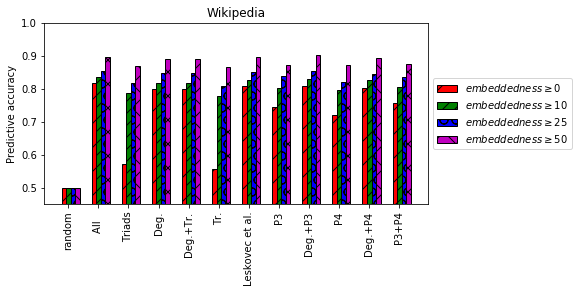

In [52]:
feature_set_names = [\
                     "All   ",
                     "Triads",    
                     "Deg.",   
                     "Deg.+Tr.", 
                    "Tr.",
                     "Leskovec et al.",    
                     "P3",
                     "Deg.+P3",
                     "P4",
                     "Deg.+P4",
                     "P3+P4"
                    ]


import matplotlib.pylab as plt
%matplotlib inline 
index = np.arange(len(feature_set_names) +1) # for random
bar_width = 0.15

rects1 = plt.bar(index, height=scores, width=bar_width, color='r', edgecolor='black', hatch="/", label='$embeddedness \geq 0$')
rects2 = plt.bar(index + bar_width, scores_e10, bar_width, color='g',edgecolor='black', hatch="//", label='$embeddedness \geq 10$')
rects3 = plt.bar(index +2*bar_width, scores_e25, bar_width, color='b', edgecolor='black', hatch="O",label='$embeddedness \geq 25$')
rects4 = plt.bar(index +3*bar_width, scores_e50, bar_width, color='m', edgecolor='black', hatch="x",label='$embeddedness \geq 50$')

plt.xticks( index + bar_width, ['random'] + feature_set_names, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.ylim(0.45, 1)
plt.ylabel("Predictive accuracy")
#plt.xlabel("Sets of features")
plt.title("Wikipedia")
plt.savefig("wikipedia_logistic_regression_compare_features.png")

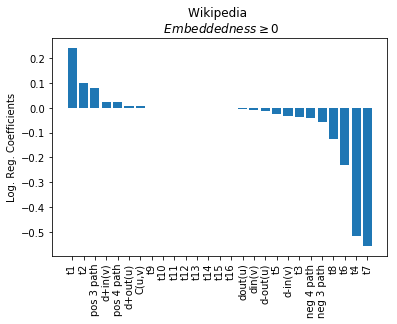

In [53]:
num_of_iterations = 10
weights = np.zeros(X_all.shape[1])
s = 0
for _ in range(num_of_iterations):
    lg = LogisticRegression(n_jobs=-2)
    X_train, X_test, y_train, y_test = train_test_split(X_all, y)
    #ss = StandardScaler()
    #X_train = ss.fit_transform(X_train)
    lg.fit(X_train, y_train)
    weights += lg.coef_[0]
    #s += lg.score(ss.transform(X_test), y_test)
weights /= num_of_iterations
s/num_of_iterations

f_names_sorted, weights_sorted = zip(*sorted((list(zip(feature_names, weights))), key=itemgetter(1), reverse=True))
x_plot = plt.arange(len(f_names_sorted))
plt.bar(x_plot, weights_sorted, label='$embeddedness \geq 0$')
plt.xticks(x_plot, f_names_sorted, rotation='vertical')
plt.ylabel("Log. Reg. Coefficients")

plt.title("Wikipedia \n $Embeddedness \geq 0$")
plt.savefig("wikipedia_logistic_regression_coefficients.png")

### Equal-to-Embeddedness experiments

In [54]:
X_zero, y_zero = [], []
for edge in g.edges():
    e = (edge.source().__hash__(), edge.target().__hash__())
    if common_neighbors[e] > 0:
        continue
    if sum(triad_features[e]) > 0:
        continue
    features = triad_features[e][:]
    features.extend( degree_features[e] )
    features.extend( [common_neighbors[e]] )
    try:
        features.extend( counts_3[e] )
    except KeyError:
        features.extend( [0, 0] )
    try:
        features.extend( counts_4[e] )
    except KeyError:
        features.extend( [0, 0] )
    
    X_zero.append( features[:] )
    y_zero.append( g.edge_properties['weight'][e] )
X_zero = np.array(X_zero)
y_zero = np.array(y_zero)

In [55]:
X = X_zero.copy()
X_all     = X_zero.copy() 
X_triads  = np.take(X, range( 0, 16), axis=1)
X_deg      = np.take(X, range(16, 22), axis=1)    
X_deg_tr   = np.take(X, range(16, 23), axis=1)    
X_leskovec     = np.take(X, range( 0, 23), axis=1) 
X_paths_3       = np.take(X, range(23, 25), axis=1) 
X_degrees_paths_3       = np.take(X, range(16, 22)+range(23, 25), axis=1)   
X_paths_4       = np.take(X, range(25, 27), axis=1)  
X_degrees_paths_4       = np.take(X, range(16, 22)+range(25, 27), axis=1)  
X_p3_p4  = np.take(X, range(23, 27), axis=1)  


feature_set_names = [\
                     "X_all   ",
                     "X_triads",    
                     "X_deg",   
                     "X_deg_tr ", 
                    "X_triangles",
                     "X_leskovec",    
                     "X_paths_3",
                     "X_degrees_paths_3",
                     "X_paths_4",
                     "X_degrees_paths_4",
                     "X_p3_p4"
                    ]
feature_sets = [\
                     X_all   ,
                     X_triads,    
                     X_deg,
                     X_deg_tr ,     
                     X_triangles, 
                     X_leskovec   ,    
                     X_paths_3     ,
                     X_degrees_paths_3,
                     X_paths_4,
                     X_degrees_paths_4,
                     X_p3_p4
                    ]

In [56]:
possible = np.where(y_zero == 1)[0]
negatives = np.where(y_zero ==  -1)[0]
positives = np.random.choice(possible, size=len(negatives))
balanced = np.concatenate([positives, negatives])

scores_zero = [0.5]
for x, name in zip(feature_sets, feature_set_names):
    score = np.mean(cross_val_score(LogisticRegression(), x[balanced], y_zero[balanced], n_jobs=-1, cv=10))
    print(name+"\t"+repr(score))
    scores_zero.append(score)

X_all   	0.80978042364509384
X_triads	0.5
X_deg	0.80140631102534066
X_deg_tr 	0.80140631102534066
X_triangles	0.47745419509729592
X_leskovec	0.80140631102534066
X_paths_3	0.72349731201323308
X_degrees_paths_3	0.80879520182874987
X_paths_4	0.69701285983412586
X_degrees_paths_4	0.8052338203873457
X_p3_p4	0.73558704941760289


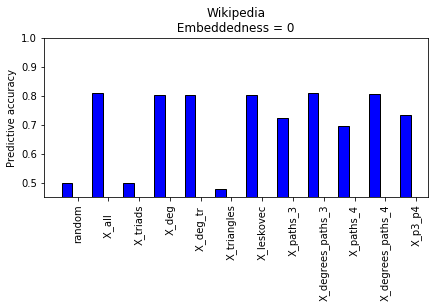

In [57]:
index = np.arange(len(feature_set_names) +1) # for random
bar_width = 0.35
rects0 = plt.bar(index, height=scores_zero, width=bar_width, color='blue', edgecolor='black')

plt.xticks( index + bar_width, ['random'] + feature_set_names, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.ylim(0.45, 1)
plt.ylabel("Predictive accuracy")
plt.title("Wikipedia\n Embeddedness = 0 ")
plt.savefig("wikipedia_logistic_regression_embed_0.png")

In [58]:
#average coefficeints after 10 runs


weights = np.zeros(X_all.shape[1])
for _ in range(10):
    lg = LogisticRegression(n_jobs=-2)
    ss = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_zero)
    lg.fit(ss.fit_transform(X_train), y_train)
    lg.fit(X_train, y_train)
    weights += lg.coef_[0]
weights /= 10


f_names_sorted, weights_sorted = zip(*sorted((list(zip(feature_names, weights))), key=itemgetter(1), reverse=True))
list(zip(f_names_sorted, weights_sorted))

[('pos 3 path', 0.096749467261956365),
 ('d+in(v)', 0.026817924754469639),
 ('pos 4 path', 0.026216621255857636),
 ('d+out(u)', 0.010384958551824166),
 ('t1', 0.0),
 ('t2', 0.0),
 ('t3', 0.0),
 ('t4', 0.0),
 ('t5', 0.0),
 ('t6', 0.0),
 ('t7', 0.0),
 ('t8', 0.0),
 ('t9', 0.0),
 ('t10', 0.0),
 ('t11', 0.0),
 ('t12', 0.0),
 ('t13', 0.0),
 ('t14', 0.0),
 ('t15', 0.0),
 ('t16', 0.0),
 ('C(u,v)', 0.0),
 ('dout(u)', -0.0060748537538082188),
 ('din(v)', -0.0076945456058722453),
 ('d-out(u)', -0.016459812305222483),
 ('d-in(v)', -0.03451247036123048),
 ('neg 4 path', -0.041078187029212523),
 ('neg 3 path', -0.062303814501209684)]

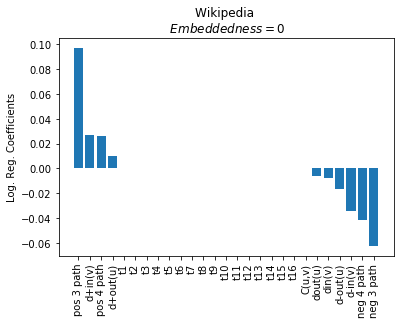

In [59]:
x_plot = plt.arange(len(f_names_sorted))
plt.bar(x_plot, weights_sorted, label='$embeddedness = 0$')
plt.ylabel("Log. Reg. Coefficients")
plt.xticks(x_plot, f_names_sorted, rotation='vertical')
plt.title("Wikipedia \n $Embeddedness = 0$")

plt.savefig("wikipedia_logistic_regression_coefficients.png")

# Ucidata

In [60]:
filename = "ucidata.txt"
g = gt.load_graph_from_csv("./data/{}".format(filename), directed=True, eprop_types=['int'], eprop_names=['weight'], string_vals=True)
g.is_directed()

True

In [66]:
triad_features  = pickle.load(open("./data/ucidata.txt_triad_features.pk", 'rb'))
degree_features = pickle.load(open("./data/ucidata.txt_degree_features.pk", 'rb'))
common_neighbors = pickle.load(open("./data/ucidata.txt_common_neighbors.pk", 'rb'))
counts_3 = pickle.load(open("./data/ucidata.txt_paths_of_length_3.pk", 'rb'))
counts_4 = pickle.load(open("./data/ucidata.txt_paths_of_length_4.pk", 'rb'))

In [67]:
common_neighbors

{(0, 1): 5,
 (0, 2): 3,
 (0, 3): 1,
 (0, 4): 3,
 (0, 5): 4,
 (0, 11): 3,
 (0, 14): 4,
 (0, 15): 5,
 (1, 2): 2,
 (1, 4): 4,
 (1, 5): 4,
 (1, 8): 4,
 (1, 9): 2,
 (1, 14): 5,
 (1, 15): 4,
 (2, 3): 2,
 (2, 5): 4,
 (2, 6): 2,
 (2, 7): 3,
 (3, 7): 1,
 (4, 6): 0,
 (4, 8): 2,
 (4, 13): 1,
 (4, 14): 4,
 (4, 15): 4,
 (5, 6): 5,
 (5, 7): 4,
 (5, 8): 3,
 (5, 10): 6,
 (5, 11): 5,
 (5, 12): 4,
 (5, 15): 5,
 (6, 7): 4,
 (6, 10): 4,
 (6, 11): 3,
 (6, 12): 2,
 (7, 10): 3,
 (7, 11): 4,
 (7, 13): 1,
 (8, 9): 4,
 (8, 10): 4,
 (8, 12): 4,
 (8, 14): 5,
 (9, 10): 3,
 (9, 12): 3,
 (9, 14): 4,
 (10, 11): 5,
 (10, 12): 6,
 (10, 14): 5,
 (10, 15): 4,
 (11, 13): 2,
 (11, 14): 3,
 (11, 15): 5,
 (12, 13): 1,
 (12, 14): 4,
 (12, 15): 4,
 (13, 15): 3,
 (14, 15): 6}

In [68]:
X, y = [], []
for edge in g.edges():
    e = (edge.source().__hash__(), edge.target().__hash__())
    features = ( triad_features[e][:]) #0..15 
    features.extend( degree_features[e][:] ) #16,17,18,19,20,21
    features.extend( [common_neighbors[e]] ) #22 
    try:
        features.extend( counts_3[e] ) #23 24 
    except KeyError:
        features.extend( [0, 0] )
    try:
        features.extend( counts_4[e] ) #25 26
    except KeyError:
        features.extend( [0, 0] )    
    X.append( features[:] )
    y.append( g.edge_properties['weight'][e] )
X = np.array(X)
y = np.array(y)

In [69]:
X_all     = X.copy()
X_triads  = np.take(X, range( 0, 16), axis=1)
X_deg      = np.take(X, range(16, 22), axis=1)    
X_deg_tr   = np.take(X, range(16, 23), axis=1)    
X_triangles   = np.take(X, range(23, 24), axis=1)  
X_leskovec     = np.take(X, range( 0, 23), axis=1)  
X_paths_3       = np.take(X, range(23, 25), axis=1)  
X_degrees_paths_3       = np.take(X, range(16, 22)+range(23, 25), axis=1)  
X_paths_4       = np.take(X, range(25, 27), axis=1)  
X_degrees_paths_4       = np.take(X, range(16, 22)+range(25, 27), axis=1)  
X_p3_p4  = np.take(X, range(23, 27), axis=1)  


feature_set_names = [\
                     "X_all   ",
                     "X_triads",    
                     "X_deg",   
                     "X_deg_tr ", 
                    "X_triangles",
                     "X_leskovec",    
                     "X_paths_3",
                     "X_degrees_paths_3",
                     "X_paths_4",
                     "X_degrees_paths_4",
                     "X_p3_p4"
                    ]
feature_sets = [\
                     X_all   ,
                     X_triads,    
                     X_deg,
                     X_deg_tr ,     
                     X_triangles, 
                     X_leskovec   ,    
                     X_paths_3     ,
                     X_degrees_paths_3,
                     X_paths_4,
                     X_degrees_paths_4,
                     X_p3_p4
                    ]

In [70]:
feature_names = ['t1', 't2','t3','t4','t5','t6','t7','t8','t9','t10','t11',\
                 't12','t13','t14','t15','t16',\
                 'd+in(v)', 'd-in(v)', 'd+out(u)', 'd-out(u)', 'din(v)', 'dout(u)', 'C(u,v)',\
                 'neg 3 path', 'pos 3 path',\
                'neg 4 path', 'pos 4 path']


In [71]:
positive_candidates = np.where(y == 1)[0]
negative_candidates = np.where(y ==  -1)[0]
if( len(positive_candidates) >  len(negative_candidates) ):
    positives = np.random.choice(positive_candidates, size=len(negative_candidates))
    negatives = negative_candidates
else:
    positives = positive_candidates
    negatives = np.random.choice(negative_candidates, size=len(positive_candidates))
    
balanced = np.concatenate([positives, negatives])

In [72]:
len(positives), len(negatives)

(29, 29)

In [73]:
scores = [0.5]
for x, name in zip(feature_sets, feature_set_names):
    score = np.mean(cross_val_score(LogisticRegression(), x[balanced], y[balanced], n_jobs=-1, cv=10))
    print(name+"\t"+repr(score))
    scores.append(score)

X_all   	0.96666666666666679
X_triads	0.98333333333333339
X_deg	0.76666666666666661
X_deg_tr 	0.75
X_triangles	0.79166666666666674
X_leskovec	0.98333333333333339
X_paths_3	0.80833333333333324
X_degrees_paths_3	0.86666666666666681
X_paths_4	0.62499999999999989
X_degrees_paths_4	0.77500000000000002
X_p3_p4	0.77500000000000013


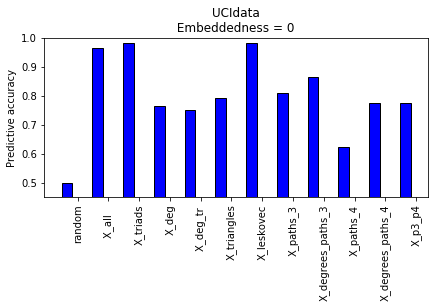

In [74]:

index = np.arange(len(feature_set_names) +1) # for random
bar_width = 0.35
rects0 = plt.bar(index, height=scores, width=bar_width, color='blue', edgecolor='black')

plt.xticks( index + bar_width, ['random'] + feature_set_names, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.ylim(0.45, 1)
plt.ylabel("Predictive accuracy")
plt.title("UCIdata\n Embeddedness = 0 ")
plt.savefig("uci_logistic_regression_embed_0.png")

In [75]:
X_zero, y_zero = [], []
for edge in g.edges():
    e = (edge.source().__hash__(), edge.target().__hash__())
    if common_neighbors[e] > 0:
        continue
    if sum(triad_features[e]) > 0:
        continue
    features = triad_features[e][:]
    features.extend( degree_features[e] )
    features.extend( [common_neighbors[e]] )
    try:
        features.extend( counts_3[e] )
    except KeyError:
        features.extend( [0, 0] )
    try:
        features.extend( counts_4[e] )
    except KeyError:
        features.extend( [0, 0] )
    
    X_zero.append( features[:] )
    y_zero.append( g.edge_properties['weight'][e] )
X_zero = np.array(X_zero)
y_zero = np.array(y_zero)

In [76]:
X = X_zero.copy()
X_all     = X_zero.copy() 
X_triads  = np.take(X, range( 0, 16), axis=1)
X_deg      = np.take(X, range(16, 22), axis=1)    
X_deg_tr   = np.take(X, range(16, 23), axis=1)    
X_leskovec     = np.take(X, range( 0, 23), axis=1) 
X_paths_3       = np.take(X, range(23, 25), axis=1) 
X_degrees_paths_3       = np.take(X, range(16, 22)+range(23, 25), axis=1)   
X_paths_4       = np.take(X, range(25, 27), axis=1)  
X_degrees_paths_4       = np.take(X, range(16, 22)+range(25, 27), axis=1)  
X_p3_p4  = np.take(X, range(23, 27), axis=1)  


feature_set_names = [\
                     "X_all   ",
                     "X_triads",    
                     "X_deg",   
                     "X_deg_tr ", 
                    "X_triangles",
                     "X_leskovec",    
                     "X_paths_3",
                     "X_degrees_paths_3",
                     "X_paths_4",
                     "X_degrees_paths_4",
                     "X_p3_p4"
                    ]
feature_sets = [\
                     X_all   ,
                     X_triads,    
                     X_deg,
                     X_deg_tr ,     
                     X_triangles, 
                     X_leskovec   ,    
                     X_paths_3     ,
                     X_degrees_paths_3,
                     X_paths_4,
                     X_degrees_paths_4,
                     X_p3_p4
                    ]

In [77]:
possible = np.where(y_zero == 1)[0]
negatives = np.where(y_zero ==  -1)[0]
print (len(negatives))
print (len(positives))
positives = np.random.choice(possible, size=len(negatives))
balanced = np.concatenate([positives, negatives])
print "Does not make sense to perform this experiment for the ucidata since it is small"

0
29
Does not make sense to perform this experiment for the ucidata since it is small


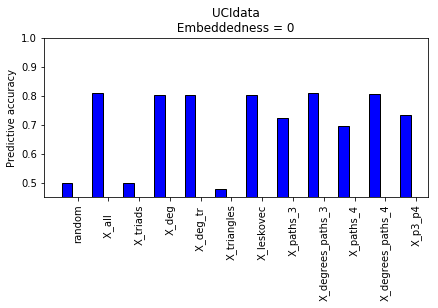

In [78]:

index = np.arange(len(feature_set_names) +1) # for random
bar_width = 0.35
rects0 = plt.bar(index, height=scores_zero, width=bar_width, color='blue', edgecolor='black')

plt.xticks( index + bar_width, ['random'] + feature_set_names, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.ylim(0.45, 1)
plt.ylabel("Predictive accuracy")
plt.title("UCIdata\n Embeddedness = 0 ")
plt.savefig("uci_logistic_regression_embed_0.png")